In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme()

First read in the data and see what we are working with. There are 2930 datapoints over 82 columns. 
There are a few columns that contain null values. Even some that contain almost exclusively null values.

In [2]:
df_orig = pd.read_csv('./data/Ames_Housing_Data.tsv', sep='\t')
# recommendation by the author to remove outliers
data = df_orig.loc[df_orig["Gr Liv Area"] <= 4000, :].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2925 non-null   int64  
 1   PID              2925 non-null   int64  
 2   MS SubClass      2925 non-null   int64  
 3   MS Zoning        2925 non-null   object 
 4   Lot Frontage     2435 non-null   float64
 5   Lot Area         2925 non-null   int64  
 6   Street           2925 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2925 non-null   object 
 9   Land Contour     2925 non-null   object 
 10  Utilities        2925 non-null   object 
 11  Lot Config       2925 non-null   object 
 12  Land Slope       2925 non-null   object 
 13  Neighborhood     2925 non-null   object 
 14  Condition 1      2925 non-null   object 
 15  Condition 2      2925 non-null   object 
 16  Bldg Type        2925 non-null   object 
 17  House Style      29

In [3]:
data.isnull().sum()[lambda s: s != 0]

Lot Frontage       490
Alley             2727
Mas Vnr Type      1774
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2914
Fence             2354
Misc Feature      2820
dtype: int64

In this notebook we will do some basic data cleaning, for example:
- Converting categorical variables to dummies using One-Hot encoding
- Removing skew from variables

### One-Hot encoding using Dummy variables

We can easily use the `pd.get_dummies()` function to transform the data to one-hot encoding.


#### Documentation
- [Pandas - get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

In [4]:
# Calculate how many columns we will get
one_hot_cols = data.dtypes[data.dtypes == object].index.to_list()
cat_cols = data[one_hot_cols]
n_dummies = cat_cols.nunique().sum()
# Subtract number of categorical variables due to drop_first later
print(f"There will be {n_dummies-len(one_hot_cols)} additional columns used for one-hot encoding.")
print(f"There are {len(data.columns)} columns in the original data.")
print(f"There are {len(one_hot_cols)} columns to be replaced.")
# 2 times the number of variables due to drop first later
print(f"So the total amount of columns will be {len(data.columns)-2*len(one_hot_cols)+n_dummies}")

There will be 222 additional columns used for one-hot encoding.
There are 82 columns in the original data.
There are 43 columns to be replaced.
So the total amount of columns will be 261


In [5]:
one_hot_cols = data.dtypes[data.dtypes == object].index.to_list()
data = pd.get_dummies(data, columns=one_hot_cols, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Columns: 261 entries, Order to Sale Condition_Partial
dtypes: bool(222), float64(11), int64(28)
memory usage: 1.5 MB


## Log transforming skewed variables

First we check for skewed data in the numerical columns. Then we simply run the `np.log()` function to do a basic correction.

In [6]:
float_cols = data.columns[data.dtypes==float]
skew_limit = 0.75
skew_vals = data[float_cols].skew()
skew_cols = (
    skew_vals
    .sort_values(ascending=False)
    .to_frame()
    .rename(columns={0:"Skew"})
    .query(f'abs(Skew) > {skew_limit}')
)

skew_cols

,Skew
BsmtFin SF 2,4.135900
Bsmt Half Bath,3.965970
Mas Vnr Area,2.565458
Lot Frontage,1.111071
Bsmt Unf SF,0.925021
BsmtFin SF 1,0.821985


Text(0.5, 0.98, 'Field: BsmtFin SF 1')

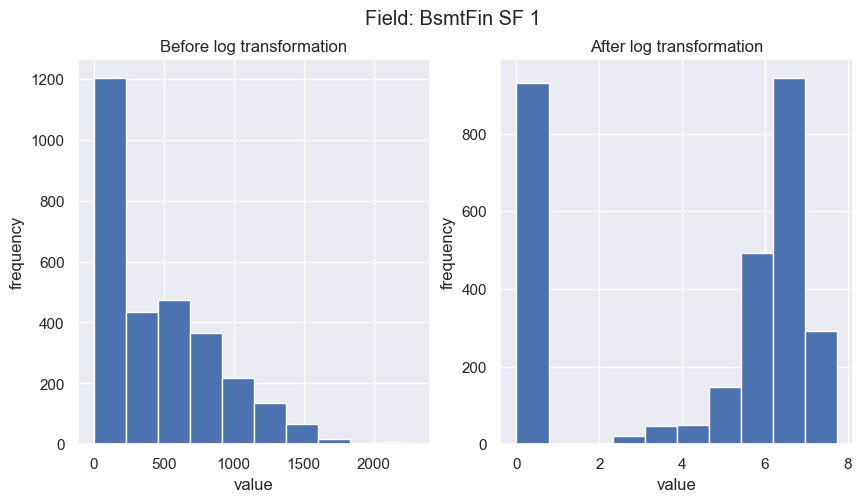

In [7]:
# Check visually how the transform performs
col = "BsmtFin SF 1"
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))
data[col].hist(ax=ax_before)
# Use np.log1p since values can be 0
data[col].apply(np.log1p).hist(ax=ax_after)
ax_before.set(title='Before log transformation', ylabel="frequency", xlabel="value")
ax_after.set(title='After log transformation', ylabel="frequency", xlabel="value")
fig.suptitle(f'Field: {col}')

In [8]:
# Apply transformation to all float columns
data[skew_cols.index.values] = data[skew_cols.index.values].apply(np.log1p)

## Plotting the data

For visualisation we select a subset of the columns. These columns contain fully present data (only a single datapoint is missing, which we can easily correct.)

Then we can use seaborn to create a pairplot between all variables.

In [17]:
# Let's pick out a few columns that we want to keep using
cols_to_use = ['Lot Area', 'Overall Qual', 'Overall Cond', 
               'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
               'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
               'Garage Cars','SalePrice']
data = data[cols_to_use]
data.fillna(0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2925 non-null   float64
 10  SalePrice       2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


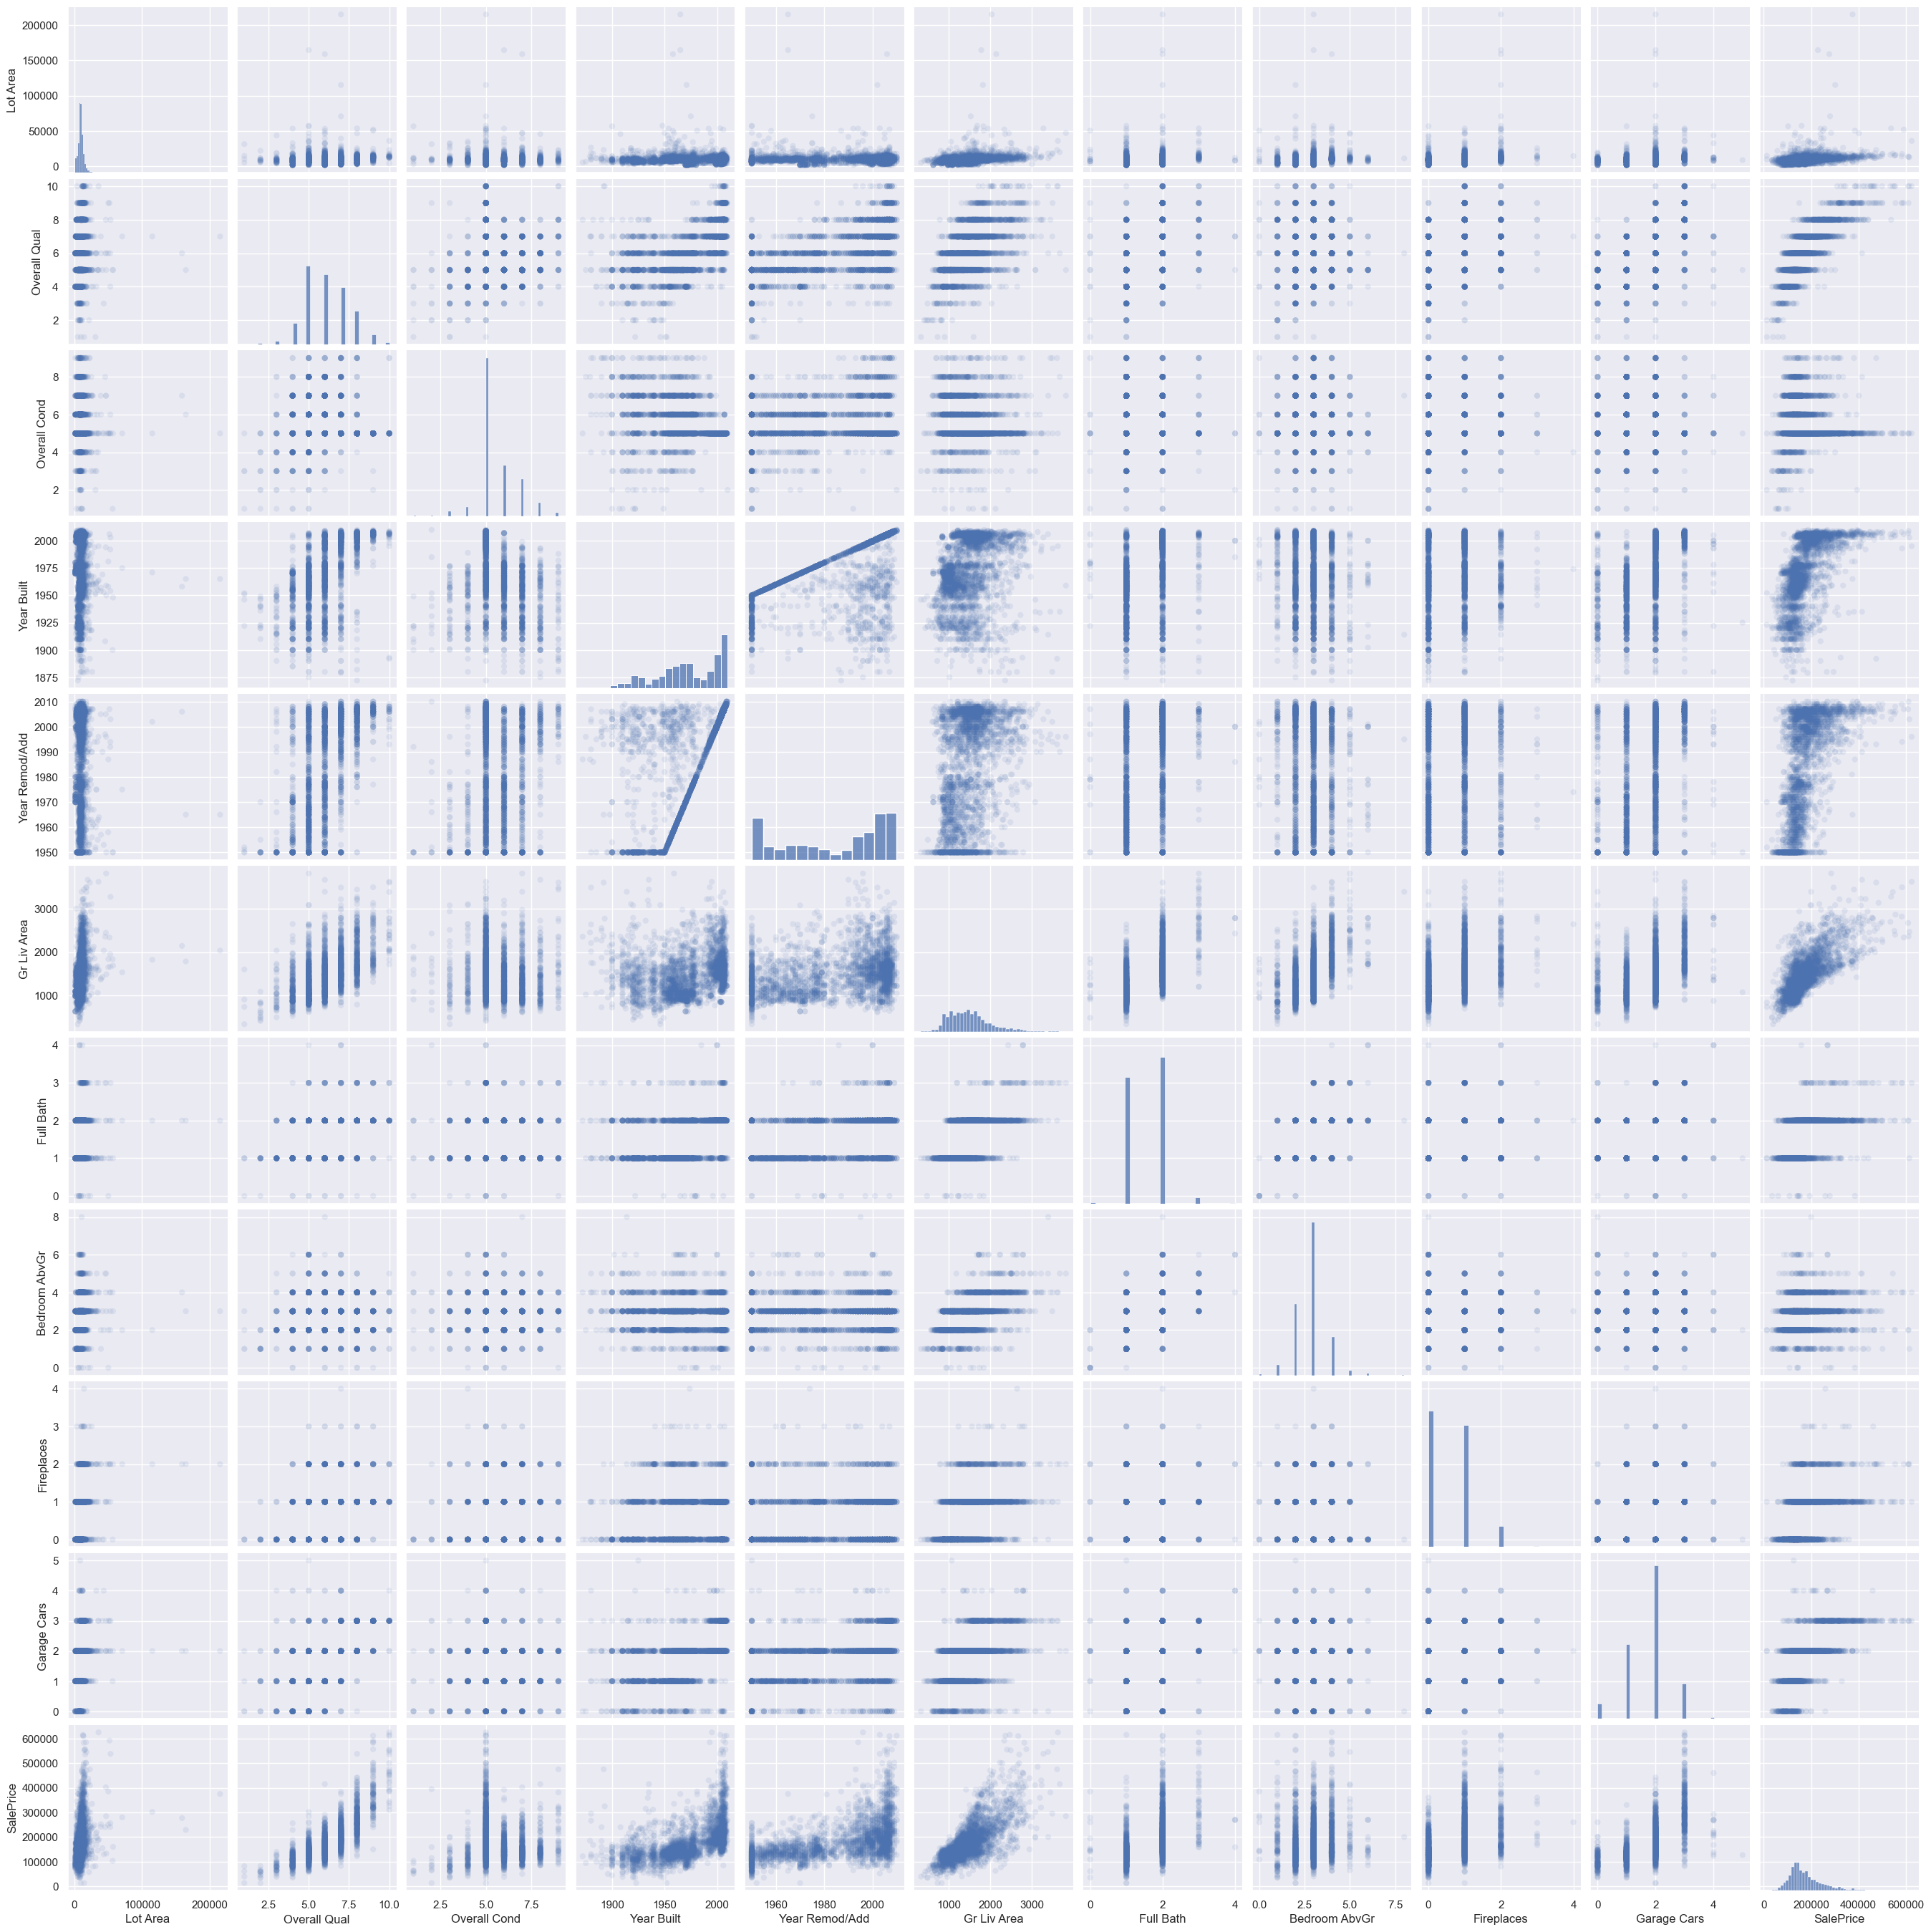

In [14]:
sns.pairplot(data, plot_kws=dict(alpha=.1, edgecolor='none'))

Let's first separate the data into features and target. In this case the `SalePrice` is what we want to predict, so this will be our target. All other variables will be features. Normally this is represented by `X` for features and `y` for the target.

In [ ]:
cols_to_use.remove('SalePrice')
X = data[cols_to_use]
y = data["SalePrice"]

## Feature Engineering

Now we can add interaction terms and polynomial features. To spot these requires good knowledge of the data. In this case there are a few obvious ones.

#### Polynomial
- `Overall Quality` => Has a quadratic dependency with `SalePrice`
- `Gr Liv Area` => Same relationship

#### Interactions
- `Overall Qual` * `Year Built` => relation, higher `SalePrice` for high qulity, new houses.
- `Overall Qual` / `Lot Area` => proportional feature, quality/sq_ft.
- `Year Built` / `Year Remodeled` => proportional, if there is more distance between these then `SalePrice` might be lower.

In [22]:
X["OQ2"] = X['Overall Qual'] ** 2
X["GLA2"] = X['Gr Liv Area'] ** 2
X['OQ_x_YB'] = X['Overall Qual'] * X['Year Built']
X['OQ_/_LA'] = X['Overall Qual'] / X['Lot Area']
X['YB_/_YR'] = X['Year Built'] / X['Year Remod/Add']

## Aggregate features

Now we also want to add the `Neighborhood` into the data. But there are quite a few neighborhoods, some of which are underrepresented. Therefore we can count each neighborhood and if there is only a small amount represented, aggregate it into an 'Other' category.

In [34]:
nbh_counts = df_orig["Neighborhood"].value_counts()
other_nbhs = list(nbh_counts[nbh_counts <= 8].index)
X["Neighborhood"] = df_orig['Neighborhood'].replace(other_nbhs, 'Other')

## Fancy Features

Another type of feature is a deviation feature. This type of feature is also known as a 'within group z-score' and is useful when base levels differ strongly between categories.

In the case below, we expect that the year that the house was built depends strongly on the style of house, and as such has a multimodal distribution. Same goes for Overall Quality and the neighbourhood.

It is in this case more interesting to ask whether "the house is older or newer than is typical for it's style" or "The house is in better/worse state than typical for it's neighborhood".

In [35]:
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create category means and standard deviations for each observation
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature  

In [36]:
X['House Style'] = df_orig['House Style']
add_deviation_feature(X, 'Year Built', 'House Style')
add_deviation_feature(X, 'Overall Qual', 'Neighborhood')

## Polynomial Features with Scikit-Learn

Adding additional polynomial features is easy with sklearn.

In [37]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)
features = ['Lot Area', 'Overall Qual']
pf.fit(data[features])
feat_cols = pf.get_feature_names_out(input_features=features)
feat_array = pf.transform(data[features])
pd.DataFrame(feat_array, columns=feat_cols)

,1,Lot Area,Overall Qual,Lot Area^2,Lot Area Overall Qual,Overall Qual^2
0,1.0,31770.0,6.0,1.009333e+09,190620.0,36.0
1,1.0,11622.0,5.0,1.350709e+08,58110.0,25.0
2,1.0,14267.0,6.0,2.035473e+08,85602.0,36.0
3,1.0,11160.0,7.0,1.245456e+08,78120.0,49.0
4,1.0,13830.0,5.0,1.912689e+08,69150.0,25.0
...,...,...,...,...,...,...
2920,1.0,7937.0,6.0,6.299597e+07,47622.0,36.0
2921,1.0,8885.0,5.0,7.894322e+07,44425.0,25.0
2922,1.0,10441.0,5.0,1.090145e+08,52205.0,25.0
2923,1.0,10010.0,5.0,1.002001e+08,50050.0,25.0
